In [7]:
from bs4 import BeautifulSoup
import pandas as pd

# === MASUKKAN PATH FILE KML KAMU DI SINI ===
kml_file = r"D:\Batavia\SEM 2026\Data & Telemetry\Jember University Circuit.kml"

# Baca isi file KML
with open(kml_file, "r", encoding="utf-8") as f:
    kml_text = f.read()

# Parse XML KML
soup = BeautifulSoup(kml_text, "xml")

# Ambil semua tag <coordinates>
# Bisa ada lebih dari satu Linestring/Placemark. Kita kumpulkan semuanya.
coords_tags = soup.find_all("coordinates")

all_points = []

for coords_tag in coords_tags:
    coords_str = coords_tag.string.strip()
    
    # Per baris / per koordinat
    for chunk in coords_str.split():
        parts = chunk.split(",")
        if len(parts) >= 2:
            lon_str, lat_str = parts[0], parts[1]
            try:
                lon = float(lon_str)
                lat = float(lat_str)
                all_points.append((lat, lon))
            except ValueError:
                # Lewatkan jika tidak bisa diubah ke angka
                continue

# Simpan ke CSV
df = pd.DataFrame(all_points, columns=["lat", "lon"])
csv_out = "UNEJ_Circuit.csv"
df.to_csv(csv_out, index=False)

print(f"Saved: {csv_out} with {len(df)} points")


Saved: UNEJ_Circuit.csv with 251 points


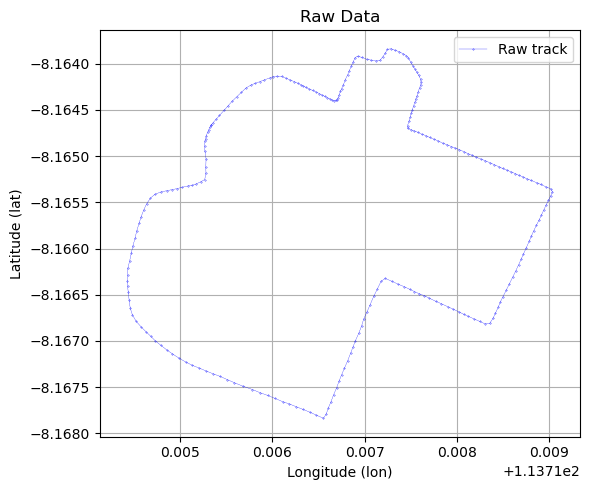

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read raw track from the cleaned file
df = pd.read_csv("UNEJ_Circuit.csv")

lat_raw = df["lat"].values
lon_raw = df["lon"].values

plt.figure(figsize=(6, 5))

# Blue dots connected by thin line
plt.plot(lon_raw, lat_raw, "b.-", markersize=0.5, linewidth=0.2, label="Raw track")

plt.xlabel("Longitude (lon)")
plt.ylabel("Latitude (lat)")
plt.title("Raw Data")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.tight_layout()

plt.savefig(
    "raw_track_UNEJ.png",   # output filename
    dpi=600,              # high resolution
    bbox_inches="tight",  # trim extra white space
    pad_inches=0.05       # small padding
)

plt.show()


        lat         lon
0 -8.164663  113.715342
1 -8.164688  113.715325
2 -8.164714  113.715313
3 -8.164741  113.715301
4 -8.164780  113.715286
Saved plot as PNG: track_smoothed_UNEJ.png


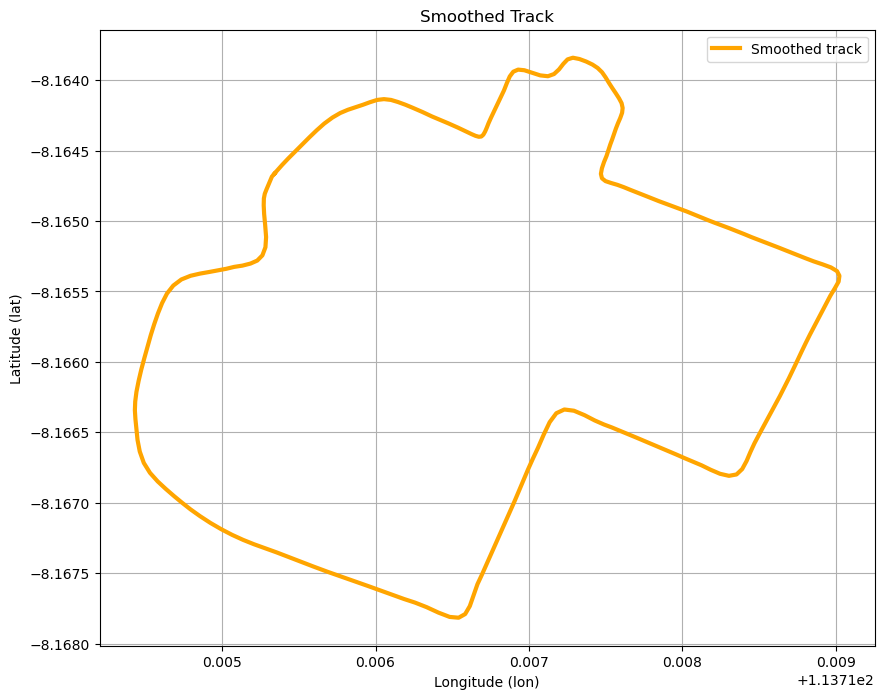

Saved smoothed CSV: UNEJ_smoothed_track.csv (251 points)


In [15]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

df = pd.read_csv("UNEJ_Circuit.csv") 

# Menampilkan data pertama
print(df.head())

# ====================================
# Proses Smoothing dengan Savitzky-Golay Filter
# ====================================
lat = df["lat"].values
lon = df["lon"].values

# Parameter filter
window_size = 11   # harus ganjil
polyorder = 5      # derajat polinom

# Terapkan Savitzky-Golay filter
lat_smooth = savgol_filter(lat, window_size, polyorder)
lon_smooth = savgol_filter(lon, window_size, polyorder)

# ====================================
# Visualisasi Smoothed Track dengan Line Lebih Tebal
# ====================================
plt.figure(figsize=(10,8))
plt.plot(lon_smooth, lat_smooth, color="orange", label="Smoothed track", linewidth=3)  # Menambah ketebalan garis
plt.xlabel("Longitude (lon)")
plt.ylabel("Latitude (lat)")
plt.title("Smoothed Track")
plt.legend()
plt.grid(True)

# Simpan plot ke file PNG (HD)
png_output = "track_smoothed_UNEJ.png"
plt.savefig(png_output, dpi=300)  # dpi=300 untuk kualitas HD
print(f"Saved plot as PNG: {png_output}")

# Menampilkan plot
plt.show()

# ====================================
# Simpan Hasil Smoothing ke CSV
# ====================================
df_smoothed = pd.DataFrame({
    "lat_smooth": lat_smooth,
    "lon_smooth": lon_smooth
})

output_csv = "UNEJ_smoothed_track.csv"
df_smoothed.to_csv(output_csv, index=False)

print(f"Saved smoothed CSV: {output_csv} ({len(df_smoothed)} points)")


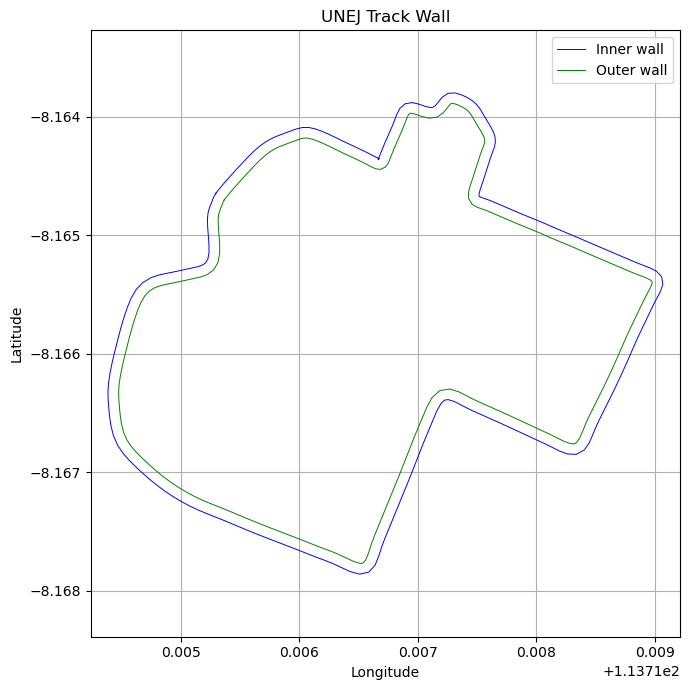

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load smoothed centerline
df = pd.read_csv("UNEJ_smoothed_track.csv")   # lat_smooth, lon_smooth
lat_s = df["lat_smooth"].values
lon_s = df["lon_smooth"].values

# Compute walls from centerline
track_width = 10         # meters
meters_per_deg = 111_000.0 # approx m per degree

dx = np.diff(lon_s)
dy = np.diff(lat_s)
L  = np.sqrt(dx**2 + dy**2)

ux = dx / L
uy = dy / L
nx = -uy
ny = ux

lon_c = (lon_s[:-1] + lon_s[1:]) / 2
lat_c = (lat_s[:-1] + lat_s[1:]) / 2

offset_deg = (track_width / 2) / meters_per_deg

lon_inner = lon_c - nx * offset_deg
lat_inner = lat_c - ny * offset_deg
lon_outer = lon_c + nx * offset_deg
lat_outer = lat_c + ny * offset_deg

# Save walls CSV 
track_wall = pd.DataFrame({
    "seg_index":  np.arange(len(lat_c)),
    "lat_center": lat_c,
    "lon_center": lon_c,
    "lat_inner":  lat_inner,
    "lon_inner":  lon_inner,
    "lat_outer":  lat_outer,
    "lon_outer":  lon_outer,
})
track_wall.to_csv("UNEJ_track_wall.csv", index=False)

# 4) CLOSE THE LOOP
lon_inner_closed = np.r_[lon_inner, lon_inner[0]]
lat_inner_closed = np.r_[lat_inner, lat_inner[0]]
lon_outer_closed = np.r_[lon_outer, lon_outer[0]]
lat_outer_closed = np.r_[lat_outer, lat_outer[0]]

# Plot closed walls save HD PNG
plt.figure(figsize=(7, 7))
plt.plot(lon_inner_closed, lat_inner_closed, "b-", linewidth=0.7, label="Inner wall")
plt.plot(lon_outer_closed, lat_outer_closed, "g-", linewidth=0.7, label="Outer wall")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("UNEJ Track Wall")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("UNEJ_track_walls.png", dpi=600, bbox_inches="tight", pad_inches=0.05)
plt.show()

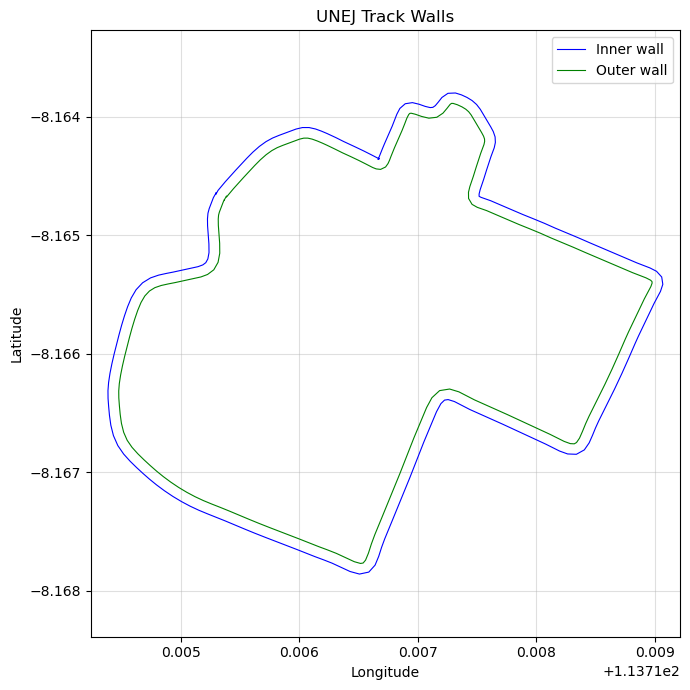

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load centerline
# -----------------------------
df = pd.read_csv("UNEJ_smoothed_track.csv")   # kolom: lat_smooth, lon_smooth
lat = df["lat_smooth"].values
lon = df["lon_smooth"].values

# Pastikan loop tertutup
if (lat[0] != lat[-1]) or (lon[0] != lon[-1]):
    lat = np.r_[lat, lat[0]]
    lon = np.r_[lon, lon[0]]

# -----------------------------
# 2) Ubah ke koordinat lokal (meter)
#    origin = titik pertama
# -----------------------------
R_earth = 6371000.0   # meter

lat0 = np.deg2rad(lat[0])
lon0 = np.deg2rad(lon[0])

lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)

dlat = lat_rad - lat0
dlon = lon_rad - lon0

x = R_earth * dlon * np.cos(lat0)   # arah "timur"
y = R_earth * dlat                 # arah "utara"

# -----------------------------
# 3) Hitung dinding dalam meter
# -----------------------------
track_width = 10.0   # meter

dx = np.diff(x)
dy = np.diff(y)
L  = np.hypot(dx, dy)
L[L < 1e-9] = 1e-9

ux = dx / L
uy = dy / L
nx = -uy
ny = ux

xc = (x[:-1] + x[1:]) / 2
yc = (y[:-1] + y[1:]) / 2

offset = track_width / 2.0

x_inner = xc - nx * offset
y_inner = yc - ny * offset
x_outer = xc + nx * offset
y_outer = yc + ny * offset

# -----------------------------
# 4) Kembali ke lat-lon
# -----------------------------
lat_c   = (yc / R_earth) + lat0
lon_c   = (xc / (R_earth * np.cos(lat0))) + lon0
lat_in  = (y_inner / R_earth) + lat0
lon_in  = (x_inner / (R_earth * np.cos(lat0))) + lon0
lat_out = (y_outer / R_earth) + lat0
lon_out = (x_outer / (R_earth * np.cos(lat0))) + lon0

lat_c   = np.rad2deg(lat_c)
lon_c   = np.rad2deg(lon_c)
lat_in  = np.rad2deg(lat_in)
lon_in  = np.rad2deg(lon_in)
lat_out = np.rad2deg(lat_out)
lon_out = np.rad2deg(lon_out)

# Tutup loop
lon_in_closed  = np.r_[lon_in,  lon_in[0]]
lat_in_closed  = np.r_[lat_in,  lat_in[0]]
lon_out_closed = np.r_[lon_out, lon_out[0]]
lat_out_closed = np.r_[lat_out, lat_out[0]]

# -----------------------------
# 5) Simpan CSV
# -----------------------------
track_wall = pd.DataFrame({
    "seg_index":  np.arange(len(lat_c)),
    "lat_center": lat_c,
    "lon_center": lon_c,
    "lat_inner":  lat_in,
    "lon_inner":  lon_in,
    "lat_outer":  lat_out,
    "lon_outer":  lon_out,
})
track_wall.to_csv("UNEJ_track_wall.csv", index=False)

# -----------------------------
# 6) Plot dan simpan PNG
# -----------------------------
plt.figure(figsize=(7, 7))
plt.plot(lon_in_closed,  lat_in_closed,  "b-", linewidth=0.8, label="Inner wall")
plt.plot(lon_out_closed, lat_out_closed, "g-", linewidth=0.8, label="Outer wall")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("UNEJ Track Walls")
plt.grid(True, alpha=0.4)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("UNEJ_track_walls.png", dpi=600,
            bbox_inches="tight", pad_inches=0.05)
plt.show()

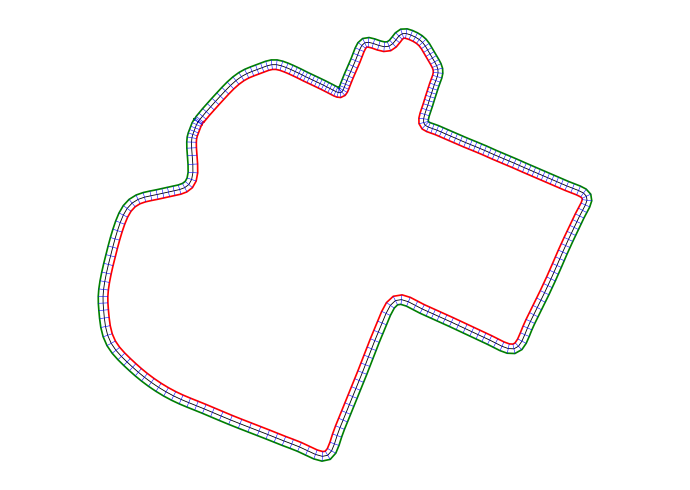

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. LOAD DATA UNEJ TRACK
# =========================
# Misal file punya kolom:
#   lat_inner, lon_inner, lat_outer, lon_outer
# atau
#   x_inner, y_inner, x_outer, y_outer  (dalam meter)
# Contoh di sini pakai lat/lon:
df = pd.read_csv("UNEJ_track_wall.csv")

lat_in  = df["lat_inner"].values
lon_in  = df["lon_inner"].values
lat_out = df["lat_outer"].values
lon_out = df["lon_outer"].values

# Pastikan loop tertutup
if lat_in[0] != lat_in[-1] or lon_in[0] != lon_in[-1]:
    lat_in  = np.r_[lat_in,  lat_in[0]]
    lon_in  = np.r_[lon_in,  lon_in[0]]
    lat_out = np.r_[lat_out, lat_out[0]]
    lon_out = np.r_[lon_out, lon_out[0]]

# =========================
# 2. CENTERLINE & LOKAL XY
# =========================
lat_c = 0.5 * (lat_in + lat_out)
lon_c = 0.5 * (lon_in + lon_out)

R    = 6371000.0
lat0 = np.deg2rad(np.mean(lat_c))

x = (np.deg2rad(lon_c) - np.deg2rad(lon_c[0])) * R * np.cos(lat0)
y = (np.deg2rad(lat_c) - np.deg2rad(lat_c[0])) * R

# inner/outer juga ke meter (supaya segmentasi rapi)
x_in = (np.deg2rad(lon_in) - np.deg2rad(lon_c[0])) * R * np.cos(lat0)
y_in = (np.deg2rad(lat_in) - np.deg2rad(lat_c[0])) * R
x_out = (np.deg2rad(lon_out) - np.deg2rad(lon_c[0])) * R * np.cos(lat0)
y_out = (np.deg2rad(lat_out) - np.deg2rad(lat_c[0])) * R

# =========================
# 3. HITUNG SEGMENT NORMAL
# =========================
dx = np.gradient(x)
dy = np.gradient(y)

L = np.sqrt(dx**2 + dy**2)
L[L < 1e-9] = 1e-9
ux = dx / L
uy = dy / L

# normal ke kiri
nx = -uy
ny = ux

# panjang half-width aktual dari inner ke outer
# (jika jarak inner–outer tidak konstan)
w_vec_x = x_out - x_in
w_vec_y = y_out - y_in
w_len   = np.sqrt(w_vec_x**2 + w_vec_y**2) / 2.0

# garis pendek tegak lurus (segmentasi)
seg_half = w_len * 0.95   # 0.95 biar sedikit di dalam dinding

xs1 = x - nx * seg_half
ys1 = y - ny * seg_half
xs2 = x + nx * seg_half
ys2 = y + ny * seg_half

# =========================
# 4. PLOTTING SEPERTI FIG 5.9
# =========================
plt.figure(figsize=(7, 5))

# Outer (merah) & inner (hijau)
plt.plot(x_out, y_out, 'r', linewidth=1.2)
plt.plot(x_in,  y_in,  'g', linewidth=1.2)

# Centerline (bisa biru tipis)
plt.plot(x, y, 'k', linewidth=0.6)

# Segmen-segmen kecil (biru)
for i in range(len(x)):
    plt.plot([xs1[i], xs2[i]], [ys1[i], ys2[i]], color='b', linewidth=0.4)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig("unej_track_segmentation.png", dpi=400)
plt.show()


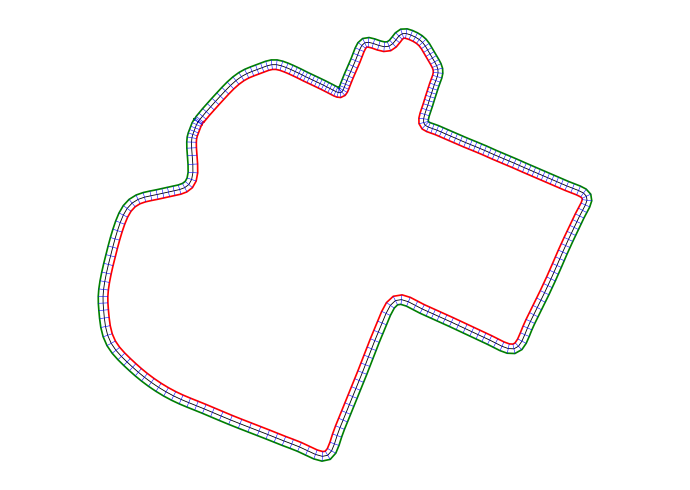

Saved to unej_track_segmentation.mat


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat   # <--- untuk simpan ke .mat

# =========================
# 1. LOAD DATA UNEJ TRACK
# =========================
df = pd.read_csv("UNEJ_track_wall.csv")

lat_in  = df["lat_inner"].values
lon_in  = df["lon_inner"].values
lat_out = df["lat_outer"].values
lon_out = df["lon_outer"].values

# Tutup loop kalau belum tertutup
if lat_in[0] != lat_in[-1] or lon_in[0] != lon_in[-1]:
    lat_in  = np.r_[lat_in,  lat_in[0]]
    lon_in  = np.r_[lon_in,  lon_in[0]]
    lat_out = np.r_[lat_out, lat_out[0]]
    lon_out = np.r_[lon_out, lon_out[0]]

# =========================
# 2. CENTERLINE & LOKAL XY
# =========================
lat_c = 0.5 * (lat_in + lat_out)
lon_c = 0.5 * (lon_in + lon_out)

R    = 6371000.0
lat0 = np.deg2rad(np.mean(lat_c))

x = (np.deg2rad(lon_c) - np.deg2rad(lon_c[0])) * R * np.cos(lat0)
y = (np.deg2rad(lat_c) - np.deg2rad(lat_c[0])) * R

x_in = (np.deg2rad(lon_in) - np.deg2rad(lon_c[0])) * R * np.cos(lat0)
y_in = (np.deg2rad(lat_in) - np.deg2rad(lat_c[0])) * R
x_out = (np.deg2rad(lon_out) - np.deg2rad(lon_c[0])) * R * np.cos(lat0)
y_out = (np.deg2rad(lat_out) - np.deg2rad(lat_c[0])) * R

# =========================
# 3. HITUNG SEGMENT NORMAL
# =========================
dx = np.gradient(x)
dy = np.gradient(y)

L = np.sqrt(dx**2 + dy**2)
L[L < 1e-9] = 1e-9
ux = dx / L
uy = dy / L

nx = -uy
ny = ux

w_vec_x = x_out - x_in
w_vec_y = y_out - y_in
w_len   = np.sqrt(w_vec_x**2 + w_vec_y**2) / 2.0

seg_half = w_len * 0.95

xs1 = x - nx * seg_half
ys1 = y - ny * seg_half
xs2 = x + nx * seg_half
ys2 = y + ny * seg_half

# =========================
# 4. PLOT TRACK SEGMENTATION
# =========================
plt.figure(figsize=(7, 5))
plt.plot(x_out, y_out, 'r', linewidth=1.2)
plt.plot(x_in,  y_in,  'g', linewidth=1.2)
plt.plot(x, y, 'k', linewidth=0.6)

for i in range(len(x)):
    plt.plot([xs1[i], xs2[i]], [ys1[i], ys2[i]], color='b', linewidth=0.4)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig("unej_track_segmentation.png", dpi=400)
plt.show()

# =========================
# 5. SAVE KE FORMAT MATLAB
# =========================
data_matlab = {
    # dinding
    "x_inner": x_in,
    "y_inner": y_in,
    "x_outer": x_out,
    "y_outer": y_out,
    # centerline
    "x_center": x,
    "y_center": y,
    # segmentasi (dua ujung tiap garis)
    "xs1": xs1,
    "ys1": ys1,
    "xs2": xs2,
    "ys2": ys2
}

savemat("unej_track_segmentation.mat", data_matlab)
print("Saved to unej_track_segmentation.mat")
